In [1]:
%matplotlib inline

In [2]:
import MeCab

m = MeCab.Tagger("-Owakati")
def tokenizer_mecab(sentence):
    kekka = m.parse(sentence)
    return kekka.split(" ")

#Mecabは学習のときにのみ使用
#IPA辞書は入れているが、neologdは入れていない

In [3]:
from janome.tokenizer import Tokenizer

t = Tokenizer()
def tokenizer_janome(sentence):
    return t.tokenize(sentence, wakati = True)

#pythonanywhereにMeCabインストール方法が分からなかったため、
#性能評価とpythonanywhereにはこちらを使用

In [4]:
import pandas as pd
import numpy as np

#csvファイルからデータ読み込み、加工
review = pd.read_csv("data_20181004.csv",names=('comment','star'))
review = review[review['star'] != '-']
review['star'] = review['star'].astype(np.float)

In [5]:
review.describe()

,star
count,101507.000000
mean,3.789427
std,0.631619
min,1.000000
25%,3.500000
50%,3.800000
75%,4.100000
max,5.000000


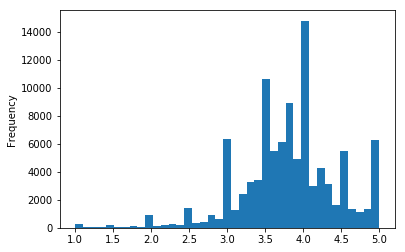

In [6]:
review['star'].plot.hist(bins=39)

実際にレビューを見て、星の数と良い評価・悪い評価の感覚を探る  
2.9以下：大多数が悪い評価  
3.0～3.5：いい評価・悪い評価がまざりあっている  
3.6以上：大多数が良い評価  

In [67]:
#高評価or低評価のレビューのみ残す（上の分布を見て、良いとも悪いともつかない中間部分のデータは捨てる）
review_sel1 = review[review['star'] < 3.0]
review_sel2 = review[review['star'] > 3.5]
review_sel = pd.concat([review_sel1,review_sel2])
review_sel['star'] = np.where(review_sel['star'] > 3.3, 1, 0)

In [8]:
review_sel.describe()

,star
count,74125.000000
mean,0.914536
std,0.279572
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
from sklearn.model_selection import train_test_split

#訓練用とテスト用にデータを分ける
X_train, X_test, y_train, y_test \
    = train_test_split(review_sel['comment'].values, review_sel['star'].values, \
    test_size=0.25, random_state=1, stratify=review_sel['star'])

In [10]:
from sklearn.feature_extraction.text import  CountVectorizer, TfidfTransformer

#ベクトルの準備
count = CountVectorizer(tokenizer=tokenizer_mecab)
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)

from sklearn.pipeline import Pipeline
#パイプライン作成
pipe_lr = Pipeline([('count', count), \
                     ('vect', tfidf), \
                     ('clf', lr)])

In [12]:
#グリッドサーチのためにパラメータキー確認
pipe_lr.get_params().keys()

dict_keys(['memory', 'steps', 'count', 'vect', 'clf', 'count__analyzer', 'count__binary', 'count__decode_error', 'count__dtype', 'count__encoding', 'count__input', 'count__lowercase', 'count__max_df', 'count__max_features', 'count__min_df', 'count__ngram_range', 'count__preprocessor', 'count__stop_words', 'count__strip_accents', 'count__token_pattern', 'count__tokenizer', 'count__vocabulary', 'vect__norm', 'vect__smooth_idf', 'vect__sublinear_tf', 'vect__use_idf', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [13]:
from sklearn.model_selection import GridSearchCV

#グリッドサーチ作成
#偏ったデータセットであるため、scoringには'f1_weighted''precision'の使用を検討したが、あまり効果は見られなかった
#n_jobsに-1をセットすると、tokenizerについてcan t get attributエラーが出る
#偏ったデータなので、clf__class_weight='balanced'を設定してみたが、かえって悪化してしまった。
param_grid = [{'clf__C':[0.1,1.0,10,100]}]
gs = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,return_train_score=True,
                  scoring=None,
#                  scoring='f1_weighted',
                  cv=2)

In [14]:
gs.fit(X_train, y_train)

#アップサンプリングした時用
#gs.fit(X_train_upsample, y_train_upsample)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf__C': [0.1, 1.0, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [15]:
print(gs.best_score_)
print(gs.best_params_)

0.9203316964366017
{'clf__C': 10}


In [16]:
results = pd.DataFrame(gs.cv_results_)
display(results.T)

,0,1,2,3
mean_fit_time,4.02616,4.05055,4.50616,5.3005
std_fit_time,0.335925,0.0498496,0.0024817,0.365304
mean_score_time,3.73091,3.28724,3.26219,3.25896
std_score_time,0.161698,0.0319916,0.0252956,0.0205837
param_clf__C,0.1,1,10,100
params,{'clf__C': 0.1},{'clf__C': 1.0},{'clf__C': 10},{'clf__C': 100}
split0_test_score,0.914523,0.91938,0.920351,0.907508
split1_test_score,0.914556,0.919089,0.920312,0.90898
mean_test_score,0.91454,0.919234,0.920332,0.908244
std_test_score,1.64506e-05,0.000145356,1.94209e-05,0.000735852


パラメータを絞ってgridsearch再実施

In [32]:
param_grid = [{'clf__C':[2,3,4,5,6,7,8],'count__tokenizer':[tokenizer_mecab]}]
gs = GridSearchCV(estimator=pipe_lr,
                  param_grid=param_grid,return_train_score=True,
                  scoring=None,
#                  scoring='f1_weighted',
                  cv=2)

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'clf__C': [2, 3, 4, 5, 6, 7, 8], 'count__tokenizer': [<function tokenizer_mecab at 0x0000020AD25D4B70>]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
print(gs.best_score_)
print(gs.best_params_)

0.9222384113107766
{'clf__C': 5, 'count__tokenizer': <function tokenizer_mecab at 0x0000020AD25D4B70>}


In [29]:
results = pd.DataFrame(gs.cv_results_)
display(results.T)

,0,1,2,3
mean_fit_time,4.42456,4.22691,4.33079,4.54137
std_fit_time,0.212038,0.128464,0.0855594,0.108128
mean_score_time,3.29393,3.38321,3.33312,3.25351
std_score_time,0.0133932,0.0267833,0.0704323,0.0106635
param_clf__C,4,6,8,12
param_count__tokenizer,<function tokenizer_mecab at 0x0000020AD25D4B70>,<function tokenizer_mecab at 0x0000020AD25D4B70>,<function tokenizer_mecab at 0x0000020AD25D4B70>,<function tokenizer_mecab at 0x0000020AD25D4B70>
params,"{'clf__C': 4, 'count__tokenizer': <function to...","{'clf__C': 6, 'count__tokenizer': <function to...","{'clf__C': 8, 'count__tokenizer': <function to...","{'clf__C': 12, 'count__tokenizer': <function t..."
split0_test_score,0.92251,0.92197,0.921179,0.919236
split1_test_score,0.921787,0.922003,0.921535,0.919485
mean_test_score,0.922148,0.921987,0.921357,0.91936


取得したパラメータを用いて、再度学習  
データが偏っているので、アップサンプリングする

In [36]:
#データが偏っているので、アップサンプリング

from sklearn.utils import resample

X_bad_upsample, y_bad_upsample = resample(X_train[y_train==0],
                                          y_train[y_train==0],
                                          replace=True,
                                          n_samples=y_train[y_train==1].shape[0],
                                          random_state=124)
X_train_upsample = np.hstack((X_train[y_train==1], X_bad_upsample))
y_train_upsample = np.hstack((y_train[y_train==1], y_bad_upsample))

In [37]:
review_upsample = pd.DataFrame(X_train_upsample,columns=['comment'])
review_upsample['star'] = y_train_upsample
review_upsample.describe()

,star
count,101684.000000
mean,0.500000
std,0.500002
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [38]:
#グリッドサーチで取得したパラメータを使用し、新たにパイプライン作成

from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(random_state=1,C=5)

from sklearn.pipeline import Pipeline
pipe_lr2 = Pipeline([('count', count), \
                     ('vect', tfidf), \
                     ('clf', lr2)])

In [42]:
pipe_lr2.fit(X_train_upsample, y_train_upsample)

Pipeline(memory=None,
     steps=[('count', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...nalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [44]:
print(pipe_lr2.score(X_test, y_test))
print(pipe_lr2.score(X_train_upsample, y_train_upsample))

0.8665551478523634
0.9667007592148223


In [46]:
pred_y = pipe_lr2.predict(X_test)

In [56]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test,pred_y)
confusion

array([[  841,   743],
       [ 1730, 15218]], dtype=int64)

In [71]:
pipe_lr2.predict(['好き','大好き','最高','楽しい','面白い','良い','爽快','傑作','感動','涙','笑える','笑い'])

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1])

In [72]:
pipe_lr2.predict(['ひどい','最低','最悪','嫌い','ダメ','駄作','つまらない'])

array([0, 0, 0, 0, 0, 0, 0])

In [73]:
#janomeに変更すると性能が変わるか実験用
pipe_lr2.set_params(count__tokenizer=tokenizer_janome)

NotFittedError: This LogisticRegression instance is not fitted yet

In [74]:
print(pipe_lr2.score(X_test, y_test))

0.8982300884955752


In [75]:
#upload用にpickle
#そのままpythonanywhereに上げると、tokenizerでエラー
pipe_lr2.set_params(count__tokenizer=None)

import pickle
import os
dest = os.path.join('.','pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
pickle.dump(pipe_lr2,  \
            open(os.path.join(dest, 'clf.pkl'), 'wb'), \
            protocol=4)


↓ここからはテスト用

In [33]:
pipe_lr.fit(X_train, y_train)
print(pipe_lr.score(X_test, y_test))
print(pipe_lr.score(X_train, y_train))

0.7407588739290085
0.853656545870062


In [19]:
#janomeに変更すると性能が変わるか実験用
pipe_lr.set_params(count__tokenizer=tokenizer_janome)
print(pipe_lr.score(X_test, y_test))

0.7138310893512851


In [30]:
pred_y = gs.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test,pred_y)
confusion

array([[  341,  1243],
       [  175, 16773]], dtype=int64)

In [25]:
gs.predict(['笑える'])

array([1])